# Inference with classifiers

# Hypothesis-testing: particle spin example in 3D

Let's use what we have learned in the [previous notebook](hypothesis_test_simple.ipynb) and apply to a research problem when the analytic likelihood is not known. 

This example concerns the measurement of particle's spin; a purely quantum mechanical property of an elementary particle. It is an intrinsic form of angular momentum, but unlike everyday spinning objects, it does not correspond to any literal rotation in space. Instead, it influences how particles behave, decay, and interact with forces, making it possible to distinguish different types of particles by their spin values.

We are going to study the spin of a hypothetical particle $X$, by performing an experiment to look at how it decays.

### Aim: 

Infer the spin-configuration of a particle $X$. 

### Dataset: 

Three observables ($x_1$, $x_2$, $x_3$) related to the decay products of $X \rightarrow aa$. The observed dataset contains $N_{obs}=10$ particle $X$ decays, and is stored in the file `data_spin.csv`.

### Hypotheses: 
* $\mathcal{H}_0$ = Spin-0 particle
* $\mathcal{H}_1$ = Spin-1 particle

### Simulation: 

We have a faithful particle decay simulator which can reproduce the observable distributions of $X \rightarrow aa$ under each hypothesis. The simulator can generate $N$ decays using the following code:
```python
sim_H0 = run_simulation(N, hypothesis='H0')
sim_H1 = run_simulation(N, hypothesis='H1')
```

### Tasks: 
1. Data exploration to understand the problem
1. Train a binary classifier to distinguish decays generated under $\mathcal{H}_0$ from those under $\mathcal{H}_1$
1. Use the classifier output to perform a hypothesis test on the observed data and infer the spin-configuration of particle $X$.


## Data exploration

We will begin by generating synthetic data (simulation) and looking at the expected observable distributions under the two hypotheses. Now the simulator is a "black-box"... all we know is that it produces faithful synthetic data under the two hypotheses.

In [15]:
from sbi_utils import run_simulation
N_train = 100000
sim_H0 = run_simulation(N_train, hypothesis='H0')
sim_H1 = run_simulation(N_train, hypothesis='H1')

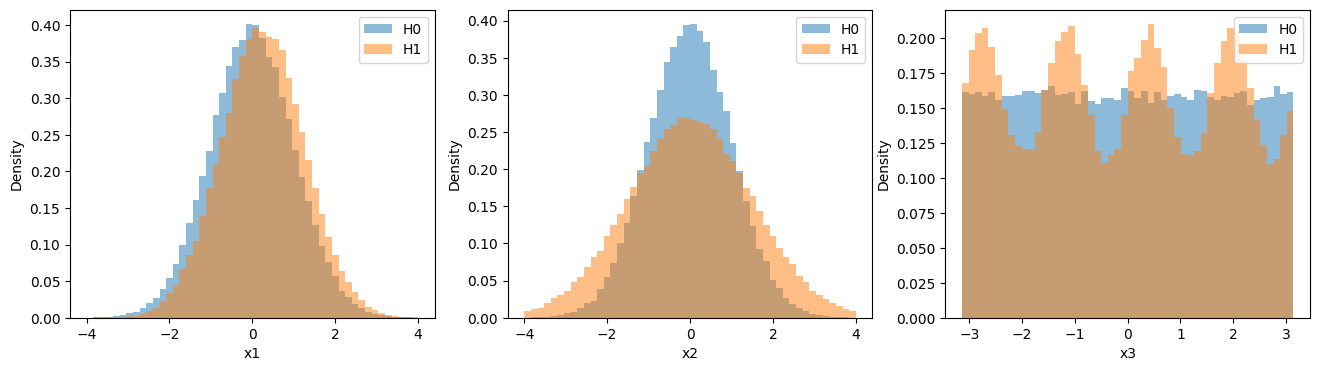

In [22]:
# Plot observable distributions of synthetic data for each hypothesis
fig, axs = plt.subplots(1, 3, figsize=(16,4)) 
axs[0].hist(sim_H0['x1'], bins=50, range=(-4,4), alpha=0.5, label='H0', density=True)
axs[0].hist(sim_H1['x1'], bins=50, range=(-4,4), alpha=0.5, label='H1', density=True)
axs[0].set_xlabel('x1')
axs[0].set_ylabel('Density')
axs[0].legend(loc='best')

axs[1].hist(sim_H0['x2'], bins=50, range=(-4,4), alpha=0.5, label='H0', density=True)
axs[1].hist(sim_H1['x2'], bins=50, range=(-4,4), alpha=0.5, label='H1', density=True)
axs[1].set_xlabel('x2')
axs[1].set_ylabel('Density')
axs[1].legend(loc='best')

axs[2].hist(sim_H0['x3'], bins=50, range=(-np.pi,np.pi), alpha=0.5, label='H0', density=True)
axs[2].hist(sim_H1['x3'], bins=50, range=(-np.pi,np.pi), alpha=0.5, label='H1', density=True)
axs[2].set_xlabel('x3')
axs[2].set_ylabel('Density')
axs[2].legend(loc='best')

plt.show()

We see that $(x1,x2)$ appear to be Gaussian distributed, where $x_1$ differs in mean between $\mathcal{H}_0$ and $\mathcal{H}_1$, while $x_2$ differs in the width. The third observable $x_3$ follows a sinusoidal-like distribution for $\mathcal{H}_1$, and is uniform for $\mathcal{H}_0$.

We can also look at 2D pairs of observables...

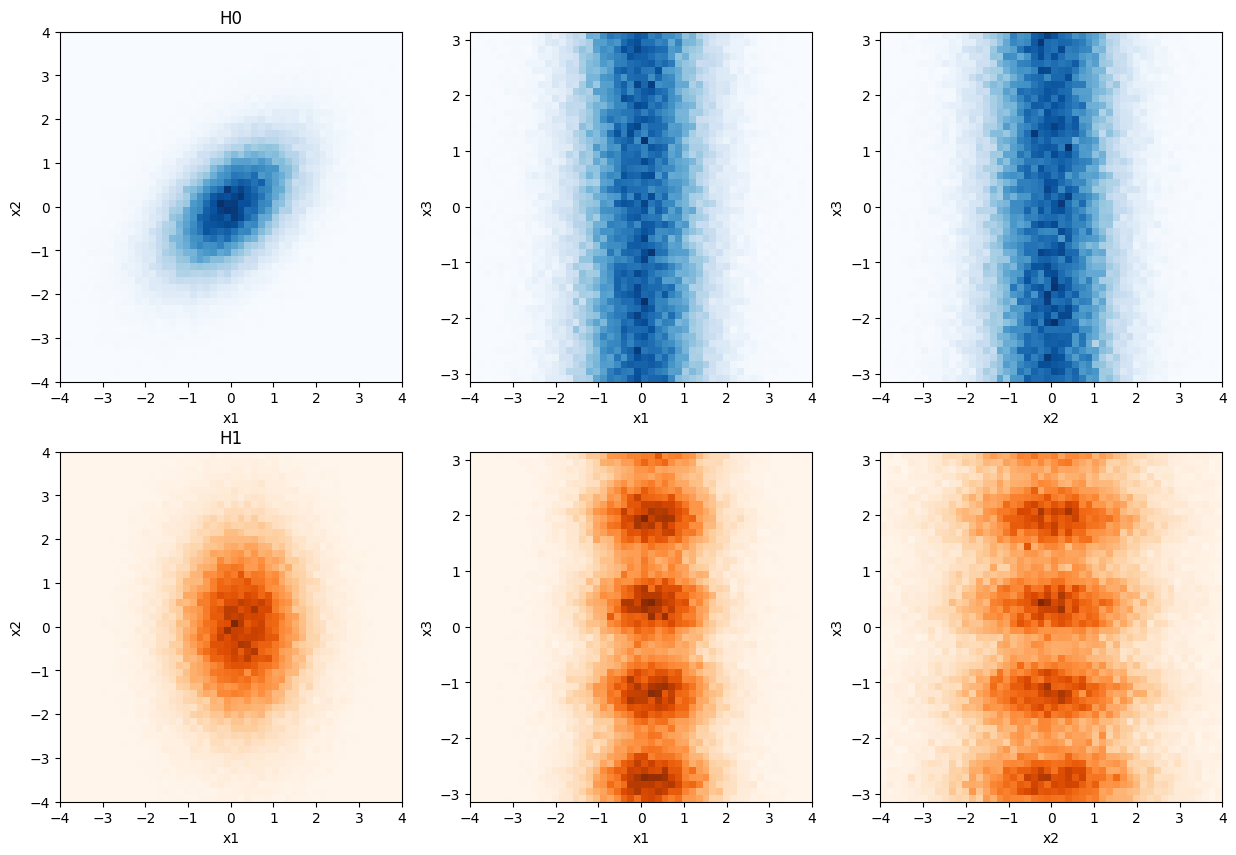

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(15,10))
axs[0][0].hist2d(sim_H0['x1'], sim_H0['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Blues')
axs[0][0].set_xlabel('x1')
axs[0][0].set_ylabel('x2')
axs[0][0].set_title('H0')
axs[1][0].hist2d(sim_H1['x1'], sim_H1['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Oranges')
axs[1][0].set_xlabel('x1')
axs[1][0].set_ylabel('x2')
axs[1][0].set_title('H1')
axs[0][1].hist2d(sim_H0['x1'], sim_H0['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Blues')
axs[0][1].set_xlabel('x1')
axs[0][1].set_ylabel('x3')
axs[0][0].set_title('H0')
axs[1][1].hist2d(sim_H1['x1'], sim_H1['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Oranges')
axs[1][1].set_xlabel('x1')
axs[1][1].set_ylabel('x3')
axs[1][0].set_title('H1')
axs[0][2].hist2d(sim_H0['x2'], sim_H0['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Blues')
axs[0][2].set_xlabel('x2')
axs[0][2].set_ylabel('x3')
axs[0][0].set_title('H0')
axs[1][2].hist2d(sim_H1['x2'], sim_H1['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Oranges')
axs[1][2].set_xlabel('x2')
axs[1][2].set_ylabel('x3')
axs[1][0].set_title('H1')
plt.show()

The first two observables $x_1$ and $x_1$ have a different correlation structure for the two hypotheses:
* $\mathcal{H}_0$ (spin 0) = positive correlation
* $\mathcal{H}_1$ (spin 1) = uncorrelated

The classifier will be able to leverage this higher-dimensional information (correlation between features) to better discriminate between $\mathcal{H}_0$ and $\mathcal{H}_1$. Better discrimination leads to an improvement in the statistical power of the test.

Let's look at how the observed dataset is distributed...

In [18]:
# Load data
data_obs = pd.read_csv('data_spin.csv')
N_obs = len(data_obs)

In [21]:
data_obs.head(n=10)

,x1,x2,x3
0,-1.137580,2.427345,-1.587226
1,0.193618,-2.112575,-1.114890
2,-0.088694,0.726530,-1.673467
3,-0.390868,-1.162352,-0.849197
4,-0.358286,-0.119108,-2.076547
5,-2.098496,0.677189,2.820093
6,0.851472,0.409719,0.306846
7,2.280547,2.090513,-1.099859
8,-0.482024,-1.209504,0.107297
9,0.330048,-0.113135,0.954608


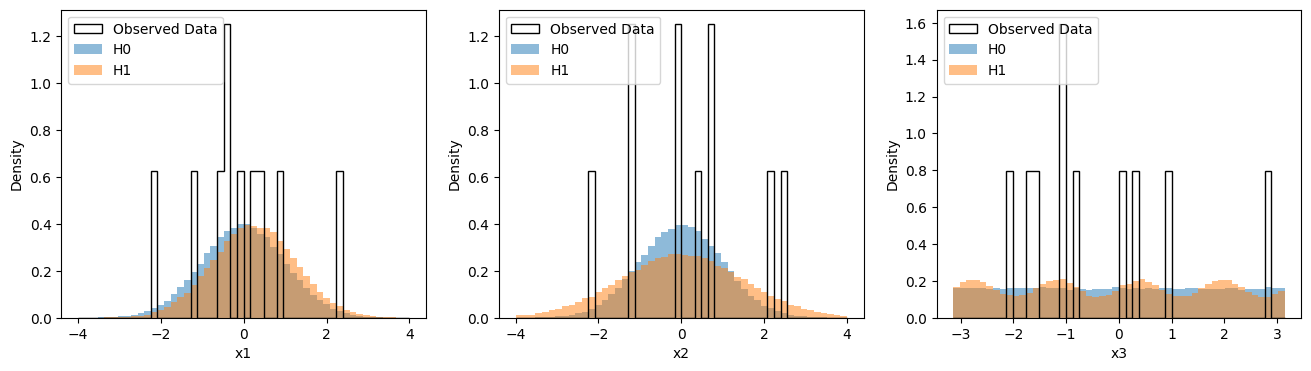

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].hist(data_obs['x1'], bins=50, range=(-4,4), color='black', histtype='step', label='Observed Data', density=True)
ax[0].hist(sim_H0['x1'], bins=50, range=(-4,4), alpha=0.5, label='H0', density=True)
ax[0].hist(sim_H1['x1'], bins=50, range=(-4,4), alpha=0.5, label='H1', density=True)
ax[0].set_xlabel('x1')
ax[0].set_ylabel('Density')
ax[0].legend(loc='upper left')

ax[1].hist(data_obs['x2'], bins=50, range=(-4,4), color='black', histtype='step', label='Observed Data', density=True)
ax[1].hist(sim_H0['x2'], bins=50, range=(-4,4), alpha=0.5, label='H0', density=True)
ax[1].hist(sim_H1['x2'], bins=50, range=(-4,4), alpha=0.5, label='H1', density=True)
ax[1].set_xlabel('x2')
ax[1].set_ylabel('Density')
ax[1].legend(loc='upper left')

ax[2].hist(data_obs['x3'], bins=50, range=(-np.pi,np.pi), color='black', histtype='step', label='Observed Data', density=True)
ax[2].hist(sim_H0['x3'], bins=50, range=(-np.pi,np.pi), alpha=0.5, label='H0', density=True)
ax[2].hist(sim_H1['x3'], bins=50, range=(-np.pi,np.pi), alpha=0.5, label='H1', density=True)
ax[2].set_xlabel('x3')
ax[2].set_ylabel('Density')
ax[2].legend(loc='upper left')

plt.show()

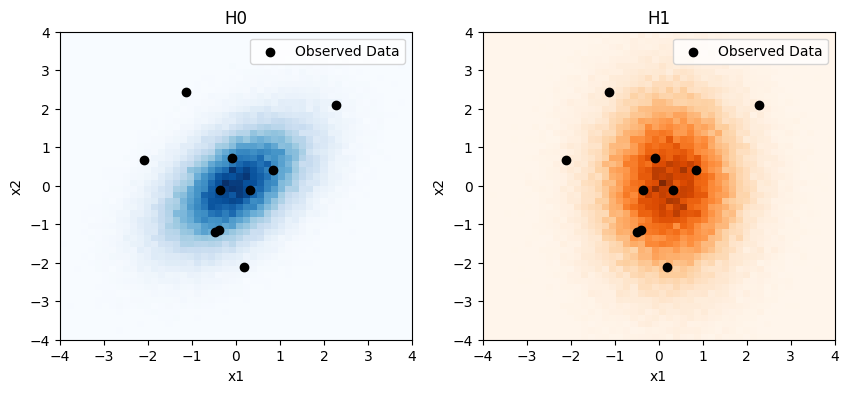

In [24]:
# 2D histogram in (x1,x2): observed data overlaid as scatter points on top of density plots
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist2d(sim_H0['x1'], sim_H0['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Blues')
axs[0].scatter(data_obs['x1'], data_obs['x2'], color='black', label='Observed Data')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].set_title('H0')
axs[0].legend()

axs[1].hist2d(sim_H1['x1'], sim_H1['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Oranges')
axs[1].scatter(data_obs['x1'], data_obs['x2'], color='black', label='Observed Data')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].set_title('H1')
axs[1].legend()

plt.show()

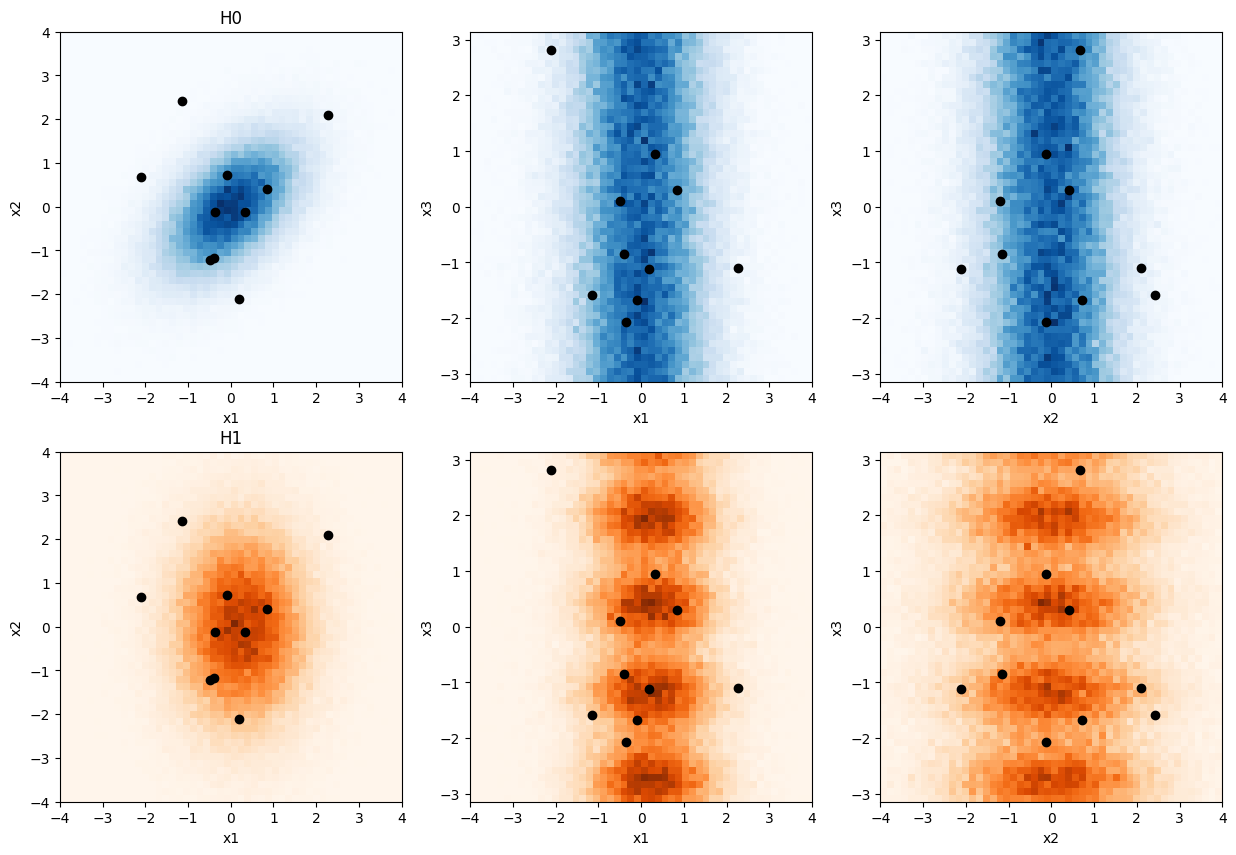

In [26]:
# Add observed data
fig, axs = plt.subplots(2, 3, figsize=(15,10))
axs[0][0].hist2d(sim_H0['x1'], sim_H0['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Blues')
axs[0][0].scatter(data_obs['x1'], data_obs['x2'], color='black', label='Observed Data')
axs[0][0].set_xlabel('x1')
axs[0][0].set_ylabel('x2')
axs[0][0].set_title('H0')
axs[1][0].hist2d(sim_H1['x1'], sim_H1['x2'], bins=50, range=[[-4,4],[-4,4]], density=True, cmap='Oranges')
axs[1][0].scatter(data_obs['x1'], data_obs['x2'], color='black', label='Observed Data')
axs[1][0].set_xlabel('x1')
axs[1][0].set_ylabel('x2')
axs[1][0].set_title('H1')
axs[0][1].hist2d(sim_H0['x1'], sim_H0['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Blues')
axs[0][1].scatter(data_obs['x1'], data_obs['x3'], color='black', label='Observed Data')
axs[0][1].set_xlabel('x1')
axs[0][1].set_ylabel('x3')
axs[0][0].set_title('H0')
axs[1][1].hist2d(sim_H1['x1'], sim_H1['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Oranges')
axs[1][1].scatter(data_obs['x1'], data_obs['x3'], color='black', label='Observed Data')
axs[1][1].set_xlabel('x1')
axs[1][1].set_ylabel('x3')
axs[1][0].set_title('H1')
axs[0][2].hist2d(sim_H0['x2'], sim_H0['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Blues')
axs[0][2].scatter(data_obs['x2'], data_obs['x3'], color='black', label='Observed Data')
axs[0][2].set_xlabel('x2')
axs[0][2].set_ylabel('x3')
axs[0][0].set_title('H0')
axs[1][2].hist2d(sim_H1['x2'], sim_H1['x3'], bins=50, range=[[-4,4],[-np.pi,np.pi]], density=True, cmap='Oranges')
axs[1][2].scatter(data_obs['x2'], data_obs['x3'], color='black', label='Observed Data')
axs[1][2].set_xlabel('x2')
axs[1][2].set_ylabel('x3')
axs[1][0].set_title('H1')
plt.show()

Can you tell by eye which class the observed data belong to? Now it is not so simple!

Let's train a classifier and set up a proper hypothesis test as in [Section 3](#simple_hypothesis_test).

## Train a classifier
In the 1D Gaussian example, we used a simple logistic regression for the classification task. This may not be sufficient when we extend to more complicated inference tasks. In this 3D example, we will now use a neural network to classify $\mathcal{H}_0$ vs $\mathcal{H}_1$. This will be a simple multi-layer perceptron (MLP), which will be trained using the simulated datasets. We will use the `torch` library to build the MLP.

It is important to note that this approach to SBI does not depend on the architecture of the classifier. You can use whichever ML model is most appropriate to the problem (e.g. BDT, CNN, GNN etc). All the method requires is training with a BCE loss function. 

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Function to convert pandas dataframe to a torch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [28]:
# Build training dataset 
sim_H0['label'] = 0
sim_H1['label'] = 1
sim = pd.concat([sim_H0, sim_H1], ignore_index=True)

# Split into test/train sets
test_size = 0.2
sim_train, sim_test = train_test_split(sim, test_size=test_size, shuffle=True)

# Convert to torch tensors
X_train = df_to_tensor(sim_train[['x1', 'x2', 'x3']])
y_train = df_to_tensor(sim_train[['label']])
X_test = df_to_tensor(sim_test[['x1', 'x2', 'x3']])
y_test = df_to_tensor(sim_test[['label']])

# Create DataLoader for batching
batch_size = 2048
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [29]:
# Define simple feedforward MLP with two hidden layers: input -> hidden -> hidden -> output (1)
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out

# Initialize model, loss function and optimizer
input_size = 3
hidden_size = 16
model = SimpleMLP(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [30]:
# Training loop: track loss per epoch for training and esting datasets
num_epochs = 50
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

Epoch [1/50], Train Loss: 0.6885, Test Loss: 0.6865
Epoch [2/50], Train Loss: 0.6861, Test Loss: 0.6841
Epoch [3/50], Train Loss: 0.6835, Test Loss: 0.6815
Epoch [4/50], Train Loss: 0.6806, Test Loss: 0.6786
Epoch [5/50], Train Loss: 0.6775, Test Loss: 0.6754
Epoch [6/50], Train Loss: 0.6742, Test Loss: 0.6721
Epoch [7/50], Train Loss: 0.6707, Test Loss: 0.6685
Epoch [8/50], Train Loss: 0.6669, Test Loss: 0.6647
Epoch [9/50], Train Loss: 0.6629, Test Loss: 0.6606
Epoch [10/50], Train Loss: 0.6587, Test Loss: 0.6563
Epoch [11/50], Train Loss: 0.6544, Test Loss: 0.6521
Epoch [12/50], Train Loss: 0.6501, Test Loss: 0.6480
Epoch [13/50], Train Loss: 0.6460, Test Loss: 0.6440
Epoch [14/50], Train Loss: 0.6420, Test Loss: 0.6403
Epoch [15/50], Train Loss: 0.6384, Test Loss: 0.6368
Epoch [16/50], Train Loss: 0.6349, Test Loss: 0.6335
Epoch [17/50], Train Loss: 0.6318, Test Loss: 0.6306
Epoch [18/50], Train Loss: 0.6290, Test Loss: 0.6279
Epoch [19/50], Train Loss: 0.6265, Test Loss: 0.6256
Ep

Let's first look at the training history to see if we have reached the plateau...

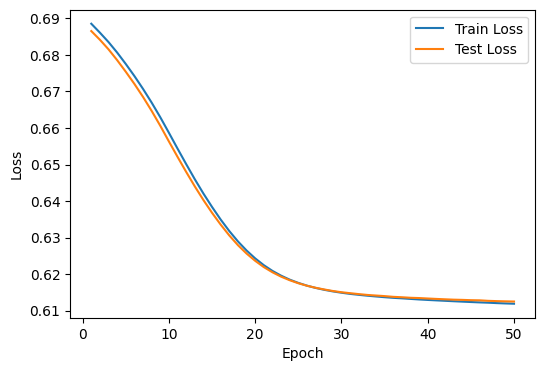

In [31]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
ax.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

Looks reasonable!

Now let's take a look at the classifier output. We will plot the distribution of $f(x)$ for $\mathcal{H}_0$ and $\mathcal{H}_1$ from the test dataset, and compare this to the classifier output distribution for the observed data. 

Does this help indicate which hypothesis the data belong to?

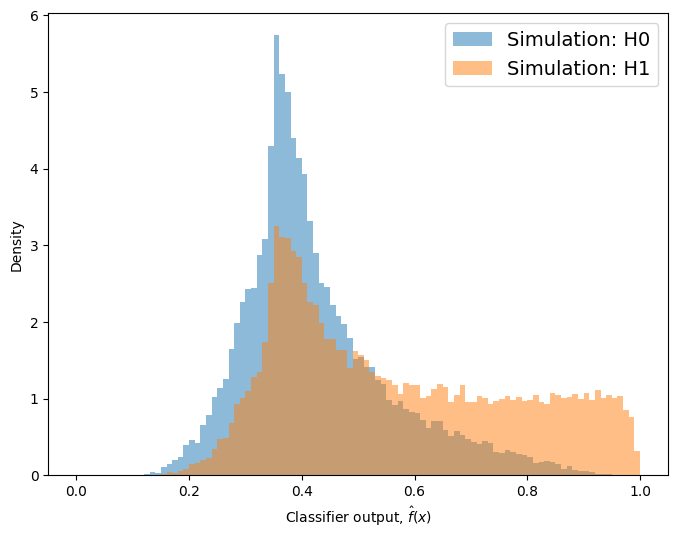

In [40]:
# Evaluate the trained model on the test simulation samples
model.eval()
with torch.no_grad():
    sim_test_outputs = model(X_test).numpy().flatten()
sim_test_labels = y_test.numpy().flatten()

# Also evaluate for the observed data
X_obs = df_to_tensor(data_obs[['x1', 'x2', 'x3']])
with torch.no_grad():
    obs_outputs = model(X_obs).numpy().flatten()

# Plot histograms of the classifier scores
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(sim_test_outputs[sim_test_labels==0], bins=100, range=(0,1), alpha=0.5, label='Simulation: H0', density=True)
ax.hist(sim_test_outputs[sim_test_labels==1], bins=100, range=(0,1), alpha=0.5, label='Simulation: H1', density=True)
#ax.hist(obs_outputs, bins=100, range=(0,1), color='black', histtype='step', label='Observed Data', density=True)
ax.set_xlabel('Classifier output, $\hat{f}(x)$')
ax.set_ylabel('Density')
ax.legend(loc='best', fontsize=14)
plt.show()

## Hypothesis testing
Following the same procedure as in [Section 3](#simple_hypothesis_test), we will now use the classifier output to perform a hypothesis test. 

<div style="background-color:#FFCCCB">

In exactly the same way, we can convert the classifier output to the density ratio using the likelihood-ratio trick:

$$
\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)} \approx \frac{p(x_i|\mathcal{H}_1)}{p(x_i|\mathcal{H}_0)}
$$

And with this, we can approximate the test-statistic over the full ($N_{obs}=10$) dataset:

$$
t = 2\Delta\mathrm{NLL} = -2 \ln{\frac{p(\mathcal{D}|\mathcal{H}_1)}{p(\mathcal{D}|\mathcal{H}_0)}} \approx -2  \sum^{N_{obs}}_{x_i \in \mathcal{D}} \ln{\bigg(\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)}\bigg)}
$$

</div>

Let's rewrite the python functions to be compatible with the torch-based model:

In [41]:
def log_likelihood_ratio_torch(X, model, clip=1e-10):
    with torch.no_grad():
        scores = model(torch.tensor(X, dtype=torch.float32)).numpy().flatten()
    # Avoid log(0) by clipping scores
    scores = np.clip(scores, clip, 1-clip)
    llr = np.log(scores / (1 - scores))
    return llr

def test_statistic_torch(X, model):
    llr = log_likelihood_ratio_torch(X, model)
    return -2 * np.sum(llr)

To perform the hypothesis test we first need to generate toy datasets under each hypothesis with $N_{obs}=10$. We will build up distributions of the learned test-statistic for each hypothesis. We then calculate the test-statistic value for the observed dataset, and determine the $p$-value with respect to the null hypothesis.

In [42]:
N_toys = 10000
test_statistic_H0_clf = []
test_statistic_H1_clf = []
for _ in range(N_toys):
    # Samples under H0
    samples_H0 = run_simulation(N_obs, hypothesis='H0')
    t_H0_clf = test_statistic_torch(samples_H0[['x1', 'x2', 'x3']].values, model)
    test_statistic_H0_clf.append(t_H0_clf)

    # Samples under H1
    samples_H1 = run_simulation(N_obs, hypothesis='H1')
    t_H1_clf = test_statistic_torch(samples_H1[['x1', 'x2', 'x3']].values, model)
    test_statistic_H1_clf.append(t_H1_clf)

# Calculate observed test statistic
t_obs_clf = test_statistic_torch(data_obs[['x1', 'x2', 'x3']].values, model)

# Calculate the p-value for H0
p_value_H0_clf = np.sum(np.array(test_statistic_H0_clf) <= t_obs_clf) / N_toys

Following this we will calculate the Type-I and Type-II errors, as well as the power of the statistical test for fixed $\alpha=0.05$. We will also compute the errors for different $\alpha$ values to construct the ROC curve.

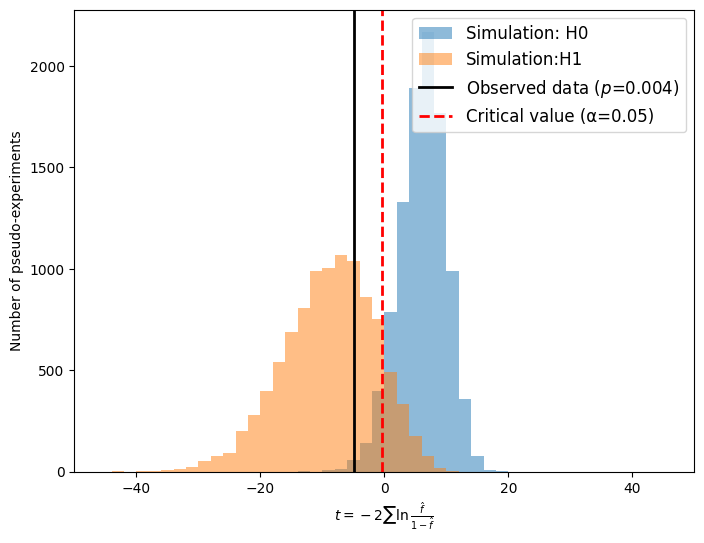

In [54]:
# Calculate the type-1 and type-2 errors for fixed alpha=0.05
alpha = 0.05
type_1_error = alpha
critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
power_clf = 1 - type_2_error_clf

# Plot the distributions of the test statistic under both hypotheses, as well as the observed case
#fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig, axs = plt.subplots(figsize=(8,6))
axs.hist(test_statistic_H0_clf, bins=50, alpha=0.5, range=(-50,50), label='Simulation: H0')
axs.hist(test_statistic_H1_clf, bins=50, alpha=0.5, range=(-50,50), label='Simulation:H1')
axs.axvline(t_obs_clf, color='black', linestyle='solid', linewidth=2, label='Observed data ($p$={:.3f})'.format(p_value_H0_clf))
axs.axvline(critical_value_clf, color='red', linestyle='dashed', linewidth=2, label='Critical value (α={})'.format(alpha))
axs.set_xlabel('$t = -2 \\sum{\\ln{\\frac{\\hat{f}}{1-\\hat{f}}}}$')
axs.set_xlim(-50, 50)
axs.set_ylabel('Number of pseudo-experiments')
axs.legend(loc='upper right', fontsize=12)
# Add text to plot with type-1, type-2 errors and power
# textstr = '\n'.join((
#     'Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
#     'Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_clf),
#     'Power (1-$\\beta$): {:.3f}'.format(power_clf)))
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=8,
#         verticalalignment='top', bbox=props)

# Plot ROC curve
# alpha_vals = np.linspace(0.0, 1.0, 1000)
# beta_vals_clf = []
# for alpha in alpha_vals:
#     critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
#     type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
#     beta_vals_clf.append(type_2_error_clf)
# fpr = alpha_vals
# tpr_clf = 1 - np.array(beta_vals_clf)
# # Calculate AUC using trapezoidal rule
# auc_clf = np.trapezoid(tpr_clf, fpr)
# axs[1].plot(fpr, tpr_clf, label='ROC Curve Classifier (AUC = {:.3f})'.format(auc_clf), color='orange')
# axs[1].plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Random Guess (AUC = 0.5)')
# axs[1].set_xlabel('False Positive Rate ($\\alpha$)')
# axs[1].set_ylabel('True Positive Rate (1-$\\beta$)')
# axs[1].legend(loc='best')
# axs[1].set_xlim(0,1)
# axs[1].set_ylim(0,1)
# plt.show()



## Summary

We were presented with a research problem with an unknown (intractable) likelihood i.e. we do not know the probability of observing data sample $(x_1,x_2,x_3)$ under hypothesis $\mathcal{H}_i$: $p(x_1,x_2,x_3|\mathcal{H}_i)$.

Nevertheless, we had access to an accurate simulation of the data. We used this simulation to train a classifier to distinguish $\mathcal{H}_0$ (spin-0 particle) from $\mathcal{H}_1$ (spin-1 particle).

The output of the classifier was used to approximate the probability density ratio. This was then used to calculate the log-likelihood-ratio test-statistic over the full dataset. Using a frequentist approach, we compared the observed value of the "learned" test-statistic to the distributions generated from toy experiments under each hypothesis. 

The data is inconsistent with the null hypothesis ($\mathcal{H}_0$) with a $p$-value of less than 0.05. Therefore we can reject $\mathcal{H}_0$ and infer that particle $X$ is spin-one!

This is an end-to-end example of using ML to perform SBI. In the next section we will go beyond hypothesis testing, and show how to use ML classifiers for parameter estimation.

<div style="background-color:#C2F5DD">

## Exercises

### 4.1 Amortized inference
One great advantage of this approach is that we can use the trained classifier to perform inference on different observations, assuming that the experiment is performed under identical conditions. This means we do not need to re-run an expensive inference procedure each time. In other words, we have **amortized** the inference for future experiments. This becomes extremely useful when dealing with problems with extremely complex likelihoods.

We re-run the experiment, where $X \rightarrow aa$ decays are recorded over a longer period such that we obtain a larger dataset. This dataset can be found in `data_spin_extension.csv`. Your task is to repeat the hypothesis-test procedure using the larger dataset with the trained classifier. How do your conclusions change? Is this in line with what you expect from taking more data?

</div>

In [ ]:
# YOUR CODE HERE

<div style="background-color:#C2F5DD">

### 4.2 Power of the statistical test
Above we evaluated the statistical power of the test statistic. Using `data_spin.csv` investigate how the power diminishes when you remove the $x_1$ observable. Compare the ROC curves obtained with the 3D and 2D inputs? What does this tell us about the impact of adding more information on the ability to resolve the two hypotheses?

</div>

In [ ]:
sim_reduced = sim[['x2', 'x3']]  # Use only x1 and x2 features
input_size = 2
# YOUR CODE HERE